In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

In [11]:
backend= AerSimulator()

t= Parameter("t")  # time acts as the parameter of the circuit
J= 1.0  # The coupling constant is assumed to be equal to 1
n_steps= 1000  # Number of Trotter steps
parametric_values= np.linspace(0, np.pi/2, 25)

# Create a parametric quantum circuit for 3-spin Heisenberg model
circuit= QuantumCircuit(3)
circuit.x(0)  # The Initial state of the qubit is set to be |001⟩

# Apply Trotterized evolution
for _ in range(n_steps):
    circuit.rxx(2*J*t/n_steps, 0, 1)
    circuit.ryy(2*J*t/n_steps, 0, 1)
    circuit.rzz(2*J*t/n_steps, 0, 1)

    circuit.rxx(2*J*t/n_steps, 1, 2)
    circuit.ryy(2*J*t/n_steps, 1, 2)
    circuit.rzz(2*J*t/n_steps, 1, 2)

circuit.measure_all()
circuit= transpile(circuit, backend)

# Static expectations at t=0
z0_0= -1  
z1_0= +1  
z2_0= +1  

z0_list, z1_list, z2_list= [], [], []
z0z1_list, z1z2_list= [], []
corr_list_01, corr_list_12= [], []
ideal_distributions= []  # Save for fidelity analysis later

for val in parametric_values:
    bound_circuit= circuit.assign_parameters({t: val})
    result= backend.run(bound_circuit, shots=1024).result()
    counts= result.get_counts()
    probabilities= [[x, y/1024] for x, y in counts.items()]
    ideal_distributions.append(probabilities)

    z0, z1, z2= 0, 0, 0
    z0z1= z1z2= 0
    for state, p in probabilities:
        z0_val= 1- (2*int(state[2]))
        z1_val= 1- (2*int(state[1]))
        z2_val= 1- (2*int(state[0]))
        z0+= z0_val*p
        z1+= z1_val*p
        z2+= z2_val*p
        z0z1+= z0_val*z1_val*p
        z1z2+= z1_val*z2_val*p

    C_01= z0z1- (z0*z1_0)
    C_12= z1z2- (z1*z2_0)

    z0_list.append(z0)
    z1_list.append(z1)
    z2_list.append(z2)
    z0z1_list.append(z0z1)
    z1z2_list.append(z1z2)
    corr_list_01.append(C_01)
    corr_list_12.append(C_12)

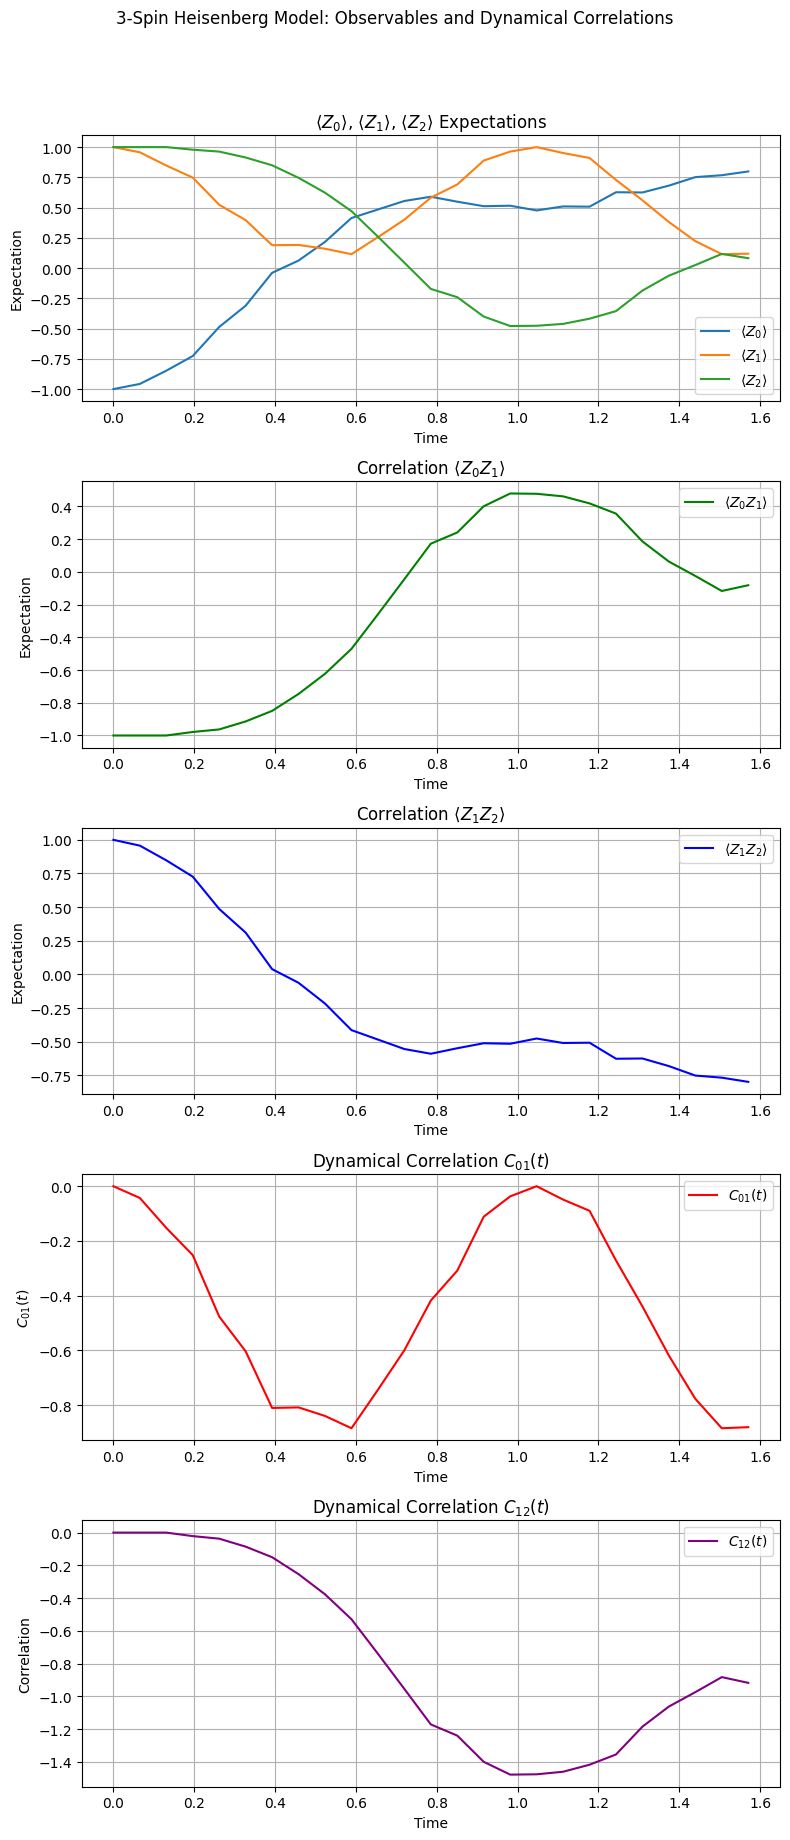

In [13]:
plt.figure(figsize=(8, 18))

# Plot the expectation values of ⟨Z_0⟩, ⟨Z_1⟩ and ⟩Z_2⟩
plt.subplot(5, 1, 1)
plt.plot(parametric_values, z0_list, label=r"$\langle Z_0 \rangle$")
plt.plot(parametric_values, z1_list, label=r"$\langle Z_1 \rangle$")
plt.plot(parametric_values, z2_list, label=r"$\langle Z_2 \rangle$")
plt.title(r"$\langle Z_0 \rangle$, $\langle Z_1 \rangle$, $\langle Z_2 \rangle$ Expectations")
plt.xlabel("Time")
plt.ylabel("Expectation")
plt.legend()
plt.grid(True)

# Plot the correlation coefficient of ⟨Z_0Z_1⟩
plt.subplot(5, 1, 2)
plt.plot(parametric_values, z0z1_list, label=r"$\langle Z_0 Z_1 \rangle$", color="green")
plt.title(r"Correlation $\langle Z_0 Z_1 \rangle$")
plt.xlabel("Time")
plt.ylabel("Expectation")
plt.legend()
plt.grid(True)

# Plot the correlation coefficient of ⟨Z_1Z_2⟩
plt.subplot(5, 1, 3)
plt.plot(parametric_values, z1z2_list, label=r"$\langle Z_1 Z_2 \rangle$", color="blue")
plt.title(r"Correlation $\langle Z_1 Z_2 \rangle$")
plt.xlabel("Time")
plt.ylabel("Expectation")
plt.legend()
plt.grid(True)

#Plot the dynamical correlation coefficient C_01(t)
plt.subplot(5, 1, 4)
plt.plot(parametric_values, corr_list_01, label=r"$C_{01}(t)$", color="red")
plt.title(r"Dynamical Correlation $C_{01}(t)$")
plt.xlabel("Time")
plt.ylabel(r"$C_{01}(t)$")
plt.legend()
plt.grid(True)

#Plot the dynamical correlation coefficient C_12(t)
plt.subplot(5, 1, 5)
plt.plot(parametric_values, corr_list_12, label=r"$C_{12}(t)$", color="purple")
plt.title(r"Dynamical Correlation $C_{12}(t)$")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.suptitle("3-Spin Heisenberg Model: Observables and Dynamical Correlations", y=1.02)
plt.subplots_adjust(top=0.95)
plt.show()

In [14]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer.noise import NoiseModel

# Get the model which simulates noise
fake_backend= FakeSherbrooke()
noise_model= NoiseModel.from_backend(fake_backend)
noisy_backend= AerSimulator(noise_model=noise_model)
noisy_circuit= transpile(circuit, noisy_backend)

noisy_distributions= []

for val in parametric_values:
    bound= noisy_circuit.assign_parameters({t: val})
    result= noisy_backend.run(bound, shots=1024).result()
    counts= result.get_counts()
    probs= [[x, y/1024] for x, y in counts.items()]
    noisy_distributions.append(probs)

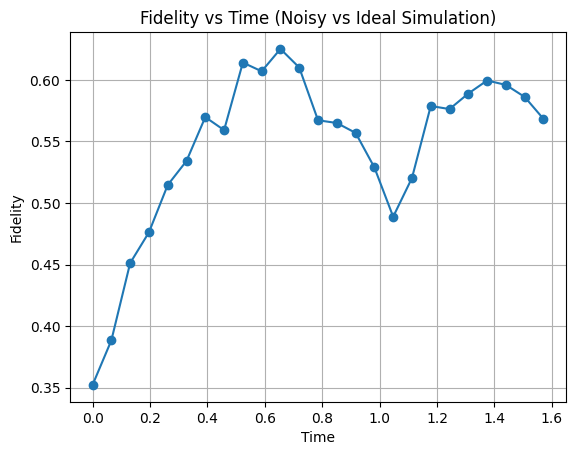

In [15]:
fidelity_values= []

for i in range(len(parametric_values)):
    ideal_list= ideal_distributions[i]
    noisy_list= noisy_distributions[i]

    # Combine all unique states (bitstrings)
    all_states= set([x[0] for x in ideal_list] + [x[0] for x in noisy_list])
    fidelity= 0

    for state in all_states:
        p_ideal= 0
        for s, p in ideal_list:
            if s== state:
                p_ideal= p
                break

        p_noisy= 0
        for s, p in noisy_list:
            if s== state:
                p_noisy= p
                break

        fidelity+= np.sqrt(p_ideal*p_noisy)

    fidelity_values.append(fidelity)

# Plot
plt.plot(parametric_values, fidelity_values, marker='o')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Time (Noisy vs Ideal Simulation)")
plt.grid(True)
plt.show()
